# ARD overpass predictor <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the `DEA Sandbox` environment
* **Special requirements:** This notebook loads data from an external .csv file (`overpass_input.csv`) from the `Supplementary_data` folder of this repository


## Background
Knowing the time of a satellite overpass (OP) at a field site is necessary to plan field work activities. While predicting the timesteps for a single field site that receives only one overpass from a given satellite is easy, it gets more complicated when you need overpass information across multiple field sites. For most sites, they will lie in a single descending (daytime) satellite acquisition. For Landsat 8 this occurs every 16 days and for Sentinel 2A / 2B this occurs every 10 days.

This notebook can be used to output a list of ordered overpasses for given field sites by providing an initial timestamp for field sites of interest. Output for multiple sites are ordered by date such that dual overpasses can be identified.

See "overpass_input.csv" as an example input file - this contains a number of field sites, with some that receive multiple acquisitions.

## Description

You must provide a start date + time for the overpass of the site you are interested in - go to https://nationalmap.gov.au/ and https://evdc.esa.int/orbit/ to get an overpass for your location (lat/long) and add this to the input file.

Take care with sites that receive multiple acquisitions, ie those that lie in the overlap of 2 acquisitions.

- Specify an output file name
- Provide an input file - this can be the example included or your own field site information
- Specify which field sites receive extra overpasses in an orbital period, ie those which lie in satellite imaging overlap
- Specify output field sites - you can select a subset of sites of interest (if adding your site to the original example file)
- Combine field site overpasses

If you wish to add or alter sites to predict for, edit the input file located at:

```
../Supplementary_data/ARD_overpass_predictor/overpass_input.csv
```

And modify the input file path to reflect. You will need to leave the 1st site in the input file (Mullion) as the notebook requires this to order multiple overpasses. 


## Getting started
To run the overpass predictor with the given input file, run all cells in the notebook starting with the "Load packages" cell.

### Load packages

In [15]:
import pandas as pd
import geopandas as gpd

In [105]:
sat_dict = {
    'AQUA': 27424,
    'LANDSAT_7': 25682,
    'LANDSAT_8': 39084,
    'LANDSAT_9': 49260,
    'METOP_A': 29499,
    'METOP_B': 38771,
    'METOP_C': 43689,
    'NOAA_15': 25338,
    'NOAA_18': 28654,
    'NOAA_19': 33591,
    'NOAA_20': 43013,
    'NPP': 37849,
    'SENTINEL_1A': 39634,
    'SENTINEL_1B': 41456,
    'SENTINEL_2A': 40697,
    'SENTINEL_2B': 42063,
    'SENTINEL_3A': 41335,
    'SENTINEL_3B': 43437,
    'TERRA': 25994
}

In [ ]:
url = 'https://satpathsapi.nemo.ga.gov.au/passes?satellites=39084&start=2022-02-15T00:00:00&end=2022-03-01T23:59:00&order=desc&format=json'

In [11]:
gdf = gpd.read_file(url)

In [177]:
satellites = ['SENTINEL_2A', 'SENTINEL_2B', 'LANDSAT_7', 'LANDSAT_8', 'LANDSAT_9']
lat, lon = -26.823824, 153.131509
local_timezone = 'Australia/Brisbane'

start_time_utc = '2022-02-17T00:00'
end_time_utc = '2022-02-25T23:59'


In [180]:
# Create URL
sat_string = '&satellites='.join([str(sat_dict[i]) for i in satellites])
url = f'https://satpathsapi.nemo.ga.gov.au/time-at-location?satellites={sat_string}&start={start_time_utc}&end={end_time_utc}&geometry=Point%20({lon}%20{lat})&format=csv'
url

'https://satpathsapi.nemo.ga.gov.au/time-at-location?satellites=40697&satellites=42063&satellites=25682&satellites=39084&satellites=49260&start=2022-02-17T00:00&end=2022-02-25T23:59&geometry=Point%20(153.131509%20-26.823824)&format=csv'

In [179]:
# Load records from API
upcoming_passes = pd.read_csv(url, parse_dates=['time'], index_col='time')

# Convert to local timezone and restrict to daytime observations
upcoming_passes.index = upcoming_passes.index.tz_convert(local_timezone)
upcoming_passes.between_time('8:00', '18:00')

,satellite_norad_id,satellite_name,satellite_orbit
time,,,
2022-02-18 10:04:10.578947+10:00,40697,SENTINEL_2A,34759
2022-02-23 10:04:00.579733+10:00,42063,SENTINEL_2B,25847
2022-02-24 08:23:59.582710+10:00,25682,LANDSAT_7,21499
2022-02-24 09:42:04.584167+10:00,49260,LANDSAT_9,2070
2022-02-25 09:54:21.583797+10:00,40697,SENTINEL_2A,34759


In [187]:
pip install contextily

  Using cached contextily-1.2.0-py3-none-any.whl (16 kB)
  Using cached mercantile-1.2.1-py3-none-any.whl (14 kB)
You should consider upgrading via the '/env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [188]:
import contextily as cx

In [184]:
url = f'https://satpathsapi.nemo.ga.gov.au/next-pass?satellites={sat_string}&format=json'
url

'https://satpathsapi.nemo.ga.gov.au/next-pass?satellites=40697&satellites=42063&satellites=25682&satellites=39084&satellites=49260&format=json'

In [189]:
passes = gpd.read_file(url)

(111.0, 156.0)

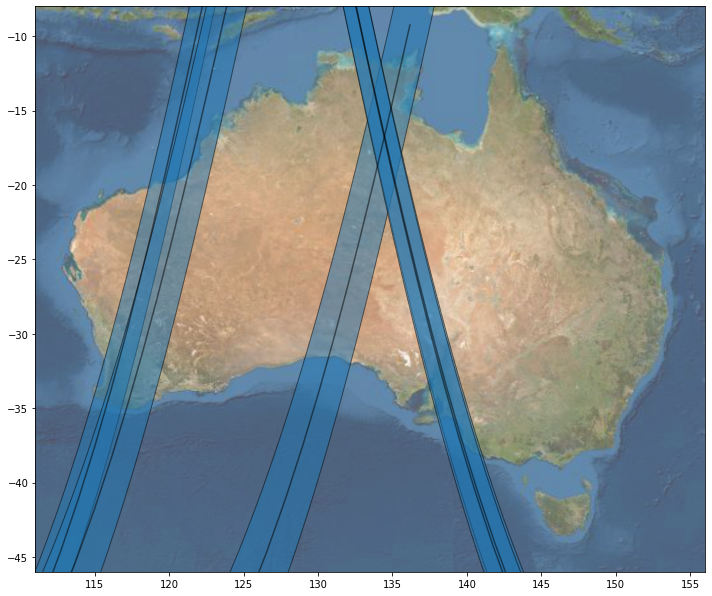

In [222]:
ax = passes.plot(figsize=(12, 12), edgecolor='black', alpha=0.5) 
cx.add_basemap(ax=ax,
               source='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', 
               crs='EPSG:4326', 
               alpha=0.7)
ax.set_ylim(-46, -8)
ax.set_xlim(111, 156)

In [ ]:
ax.set

In [ ]:
cx.providers.Stamen.Watercolor

In [196]:
passes

,start,end,satellite,geometry
0,2022-02-17T01:53:07+00:00,2022-02-17T02:12:29+00:00,"{'norad_id': 39084, 'name': 'LANDSAT_8', 'orbi...",GEOMETRYCOLLECTION (POLYGON ((107.73671 -53.21...
1,2022-02-17T01:19:41+00:00,2022-02-17T01:35:18+00:00,"{'norad_id': 42063, 'name': 'SENTINEL_2B', 'or...",GEOMETRYCOLLECTION (POLYGON ((118.60545 -56.54...
2,2022-02-17T02:03:24+00:00,2022-02-17T02:24:04+00:00,"{'norad_id': 40697, 'name': 'SENTINEL_2A', 'or...",GEOMETRYCOLLECTION (POLYGON ((107.57268 -53.97...
3,2022-02-17T13:09:53+00:00,2022-02-17T13:32:48+00:00,"{'norad_id': 49260, 'name': 'LANDSAT_9', 'orbi...",GEOMETRYCOLLECTION (POLYGON ((128.28393 8.0107...
4,2022-02-17T11:52:22+00:00,2022-02-17T12:15:18+00:00,"{'norad_id': 25682, 'name': 'LANDSAT_7', 'orbi...",GEOMETRYCOLLECTION (POLYGON ((129.11375 4.3250...


### Specify output file name
This is the name of the .csv the notebook will output. This .csv will contain your combined predictions.

In [2]:
# You can rename the .csv to any desired output filename here. Default is "output_overpass_pred.csv"
output_path = '../Supplementary_data/ARD_overpass_predictor/output_overpass_pred.csv'

### Specify input file containing initial overpass data for a given site

Read in base overpass file ```overpass_input.csv``` 

- Input date times must be in UTC
- Make sure the necessary dates for your site are imported correctly - should be YYYY-MM-DD HH:MM:SS in 24hr format

In [3]:
# Read in base file 'overpass_input.csv'
# Edit this file with new field sites, or load your own file with field sites as needed.
# You don't need to input Path / Row or Lat / Long. The notebook only requires start times for the relevant satellites.
base_file_path = '../Supplementary_data/ARD_overpass_predictor/overpass_input.csv'
overpass = pd.read_csv(base_file_path, index_col='Site', 
                       parse_dates=['landsat_8', 'sentinel_2a', 'sentinel_2b', 'landsat_8_2', 'sentinel_2a_2', 'sentinel_2b_2'])
overpass
#"NaT" values are expected - indicates a date was not entered in input file. 

,Latitude,Longitude,Path,Row,landsat_8,landsat_8_2,sentinel_2a,sentinel_2a_2,sentinel_2b,sentinel_2b_2
Site,,,,,,,,,,
Mullion,-35.123,148.862,91,84,2019-11-29 23:43:00,2019-11-20 23:49:00,2019-12-20 23:58:00,2019-12-14 00:07:00,2019-12-15 23:58:00,2019-12-19 00:07:00
Lake_George,-35.094,149.463,90,84,2019-11-29 23:43:00,NaT,2019-12-20 23:58:00,NaT,2019-12-15 23:58:00,NaT
Narrabundah,-35.334,149.145,90,85,2019-11-29 23:43:00,2019-11-20 23:49:00,2019-12-20 23:58:00,NaT,2019-12-15 23:58:00,NaT


In [4]:
# Set a list for field sites included in prediction. If adding to the field sites, please leave the 1st entry, "Mullion",
# as this is used to order secondary overpasses.
sites = list(overpass.index)
sites[0] # outputs 1st site. Should be 'Mullion'

'Mullion'

In [5]:
# Set satellite timesteps for overpasses
# Depending on your application, you may want to add more accurate timesteps - but note that times used as inputs are 
# for the beginning of the acquisition, not the actual overpass time at a specific site.
l8_timestep = timedelta(days=16)
s2a_timestep = timedelta(days=10)
s2b_timestep = timedelta(days=10)

In [6]:
# Specify start date
l8_startdate = overpass['landsat_8'] 
l8_startdate_2 = overpass['landsat_8_2'] 
sentinel2a_startdate = overpass['sentinel_2a']
sentinel2a_2_startdate = overpass['sentinel_2a_2']
sentinel2b_startdate = overpass['sentinel_2b']
sentinel2b_2_startdate = overpass['sentinel_2b_2']
sentinel2a_startdate

Site
Mullion       2019-12-20 23:58:00
Lake_George   2019-12-20 23:58:00
Narrabundah   2019-12-20 23:58:00
Name: sentinel_2a, dtype: datetime64[ns]

### Project Times
The following cell calculates times for Landsat and Sentinel overpasses for field sites. This is done by multiplying a number of desired iterations by the overpass frequency. 

Overpass frequencies for Landsat 8 = 16 days, Sentinel = 10 days. Increasing the number X in "for i in range(X):" will increase the number of iterations to predict over per satellite. An initial value of 20 iterations is set for L8, and 32 for Sentinel to result in the same total time period (320 days) to predict over.

Predictions are also calculated for secondary overpasses for each site.

In [7]:
# Landsat 8 overpass prediction for 20*(overpass frequency) - ie 20*16 = 320 days. You can change this as desired,
# to get overpass predictions for n days. n = x*(OP freq). X is arbitrarily set to 20 to give 320 days as a base example
landsat = list()
for i in range(20):
    landsat.append(l8_startdate + l8_timestep*(i))
landsat = pd.DataFrame(landsat)

# Sentinel 2a overpass prediction for 32 * the overpass frequency, this is to give a similar total time to the L8 prediction.
# OP frequency for Sentinel = 10 days, n days = 32*10 = 320
Sentinel_2A = []  
for i in range(32):
    Sentinel_2A.append(sentinel2a_startdate + s2a_timestep * (i))
Sentinel_2A = pd.DataFrame(Sentinel_2A)

# Sentinel 2b
Sentinel_2B = []
for i in range(32):
    Sentinel_2B.append(sentinel2b_startdate + s2b_timestep * (i))
    
Sentinel_2B = pd.DataFrame(Sentinel_2B)

# Landasat_2
# Prediction for L8 overpasses at sites which are covered by more than 1 overpass in a 16-day period.
# - only Mullion in example .csv
landsat_2 = []
for i in range(20):
    landsat_2.append(l8_startdate_2 + l8_timestep*(i))
landsat_2 = pd.DataFrame(landsat_2)

# Sentinel_2A_2
# Sentinel 2a secondary (Mullion)
Sentinel_2A_2 = []  
for i in range(32):
    Sentinel_2A_2.append(sentinel2a_2_startdate + s2a_timestep * (i))
Sentinel_2A_2 = pd.DataFrame(Sentinel_2A_2)

# Sentinel_2B_2
# Sentinel 2b secondary (Lake_George, Narrabundah)
Sentinel_2B_2 = []
for i in range(32):
    Sentinel_2B_2.append(sentinel2b_2_startdate + s2b_timestep * (i))
Sentinel_2B_2 = pd.DataFrame(Sentinel_2B_2)

### Append dataframes for sites that recieve more than 1 overpass in an orbital period.
- If adding sites to the input file, please leave in "Mullion" - the 1st entry, as this is used to order secondary overpasses by.

In [8]:
# Combine Landsat 8 data (base plus extra overpasses)
L8_combined2 = landsat.append(landsat_2)
drop_label_L8 = L8_combined2.reset_index(drop=True)
L8_combined2 = drop_label_L8.sort_values(by='Mullion') 
L8_combined2.index.names = ['Landsat_8']

# Combine Sentinel 2A data (base plus extra overpasses)
S2A_combined = Sentinel_2A.append(Sentinel_2A_2)
drop_label_S2A = S2A_combined.reset_index(drop=True)
S2A_combined = drop_label_S2A.sort_values(by='Mullion') 
S2A_combined.index.names = ['Sentinel_2A']

# Combine Sentinel 2B data (base plus extra overpasses)
S2B_combined = Sentinel_2B.append(Sentinel_2B_2)
drop_label_S2B = S2B_combined.reset_index(drop=True)
S2B_combined = drop_label_S2B.sort_values(by='Mullion') 
S2B_combined.index.names = ['Sentinel_2B']

# Add satellite label to each entry in "Sat" column
S2A_combined['Sat'] = 'S2A'
S2B_combined['Sat'] = 'S2B'
L8_combined2['Sat'] = 'L8'

combined1 = S2B_combined.append(S2A_combined)
combined = combined1.append(L8_combined2)
df = pd.DataFrame(combined)

In [9]:
# Use a "time dummy" to force a re-order of data by date, to standardise across dataframes.
today = datetime.today()
timedummy = []
t0 = datetime(today.year, today.month, 1)
dummystep = timedelta(days=2)

for i in range(300):
    timedummy.append(t0 + dummystep * (i))
    
timedummy = pd.DataFrame(timedummy)
df['DateStep'] = timedummy

### Output field sites
For new field sites, comment "#" out the old, add the new in the same format.

In [10]:
# Create a new df for each field site of interest. To add a new field site, add in same format ie 
# "Field_Site = df[['Field_Site', 'Sat', 'DateStep']].copy()" - if you are appending to the original file simply add in "site4 = sites[3]" 
# and "Site4 = df[[(site4), 'Sat', 'DateStep']].copy()" in the appropriate section below.
site1 = sites[0]
site2 = sites[1]
site3 = sites[2]
#site4 = sites[3]

Site1 = df[[(site1), 'Sat', 'DateStep']].copy()
Site2 = df[[(site2), 'Sat', 'DateStep']].copy()
Site3 = df[[(site3), 'Sat', 'DateStep']].copy()
#Site4 = df[[(site4), 'Sat', 'DateStep']].copy()

In [11]:
# Reorder by date for each site, include satellite tags for each date. 
# Add new lines for new sites as needed.
Site1 = (Site1.sort_values(by=[(site1), 'DateStep'])).reset_index(drop=True)
Site2 = (Site2.sort_values(by=[(site2), 'DateStep'])).reset_index(drop=True)
Site3 = (Site3.sort_values(by=[(site3), 'DateStep'])).reset_index(drop=True)
#Site4 = (Site4.sort_values(by=[(site4), 'DateStep'])).reset_index(drop=True)

### Optional - output individual field site.
- if you wish to output multiple field sites, skip this step.

In [12]:
# Use this cell to ouput an individual field site
# Write individual site to excel: take out "#" symbol below, or add new line for new site in this format:

#Site1.to_excel('Site1.csv')
#Site2.to_excel('Site2.csv')

### Combine dataset
The overpass predictions are combined and output to the specified "output_path". Times are in the same timezone as the input file. The example file used is in UTC, but you can also run the notebook on local times.

To convert UTC (or whatever your input time was) to local time, ie AEST (or any other time zone), add 10h to the times or 11 for AEDT. This part is in the below cell, commented out. Remove the #'s to run the command on your desired column, and it will add the timestep.

Yay, you have a list of overpasses!

In [13]:
combined_sites = ([Site1, Site2, Site3]) ## If you have more sites, ie you have added 1 or more, add here! An example is provided below if you have a total of 5 sites.
#combined_sites = ([Site1, Site2, Site3, Site4, Site5])

merged = pd.concat(combined_sites, axis=1)
merged = merged.rename_axis("Overpass", axis="columns")
output = merged.drop(['DateStep'], axis=1)

#add timestep: (comment out / delete hash to use as applicable - must include column/site name) - ignore the error
#output['Mullion']=output['Mullion']+datetime.timedelta(hours=10)
#output['Lake_George']=output['Lake_George']+datetime.timedelta(hours=10)
#output['Narrabundah']=output['Narrabundah']+datetime.timedelta(hours=10)

output.to_csv(output_path)
output.head(20)

Overpass,Mullion,Sat,Lake_George,Sat,Narrabundah,Sat
0,2019-11-20 23:49:00,L8,2019-11-29 23:43:00,L8,2019-11-20 23:49:00,L8
1,2019-11-29 23:43:00,L8,2019-12-15 23:43:00,L8,2019-11-29 23:43:00,L8
2,2019-12-06 23:49:00,L8,2019-12-15 23:58:00,S2B,2019-12-06 23:49:00,L8
3,2019-12-14 00:07:00,S2A,2019-12-20 23:58:00,S2A,2019-12-15 23:43:00,L8
4,2019-12-15 23:43:00,L8,2019-12-25 23:58:00,S2B,2019-12-15 23:58:00,S2B
5,2019-12-15 23:58:00,S2B,2019-12-30 23:58:00,S2A,2019-12-20 23:58:00,S2A
6,2019-12-19 00:07:00,S2B,2019-12-31 23:43:00,L8,2019-12-22 23:49:00,L8
7,2019-12-20 23:58:00,S2A,2020-01-04 23:58:00,S2B,2019-12-25 23:58:00,S2B
8,2019-12-22 23:49:00,L8,2020-01-09 23:58:00,S2A,2019-12-30 23:58:00,S2A
9,2019-12-24 00:07:00,S2A,2020-01-14 23:58:00,S2B,2019-12-31 23:43:00,L8


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2021

## Tags